In [1]:
import numpy as np
import random 
import gym

import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import pandas as pd

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

In [2]:
# seed random number generators for reproducable results
np.random.seed (0)
random.seed(0)
tf.set_random_seed(0)
#tf.random.set_seed(0)

# SAMPLE DATA

In [3]:
# for details see: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
CART_POS="cartPos"
CART_VEL="cartVel"
PEND_POS="pendPos"
PEND_VEL="pendVel"
EPISODE="episode"
STEP="step"
ACTION="action"
    
def sample_data (episodes=10000, seed=0):
    env = gym.make ("CartPole-v1")
    env.np_random.seed(0)
    
    ### CREATE EMPTY Pandas dataset
    transitions = []

    ### SAMPLE DATA
    for episode in range (episodes):
        #print ("Start of episode %d" % episode)
        obs = env.reset()
        step =0
        done = False

        while step < 500 and not done:
            step += 1
            action = env.action_space.sample()

            transitions.append({CART_POS:obs[0], CART_VEL:obs[1], 
                             PEND_POS:obs[2], PEND_VEL:obs[3],
                             EPISODE:episode, STEP:step, ACTION:action})

            obs, reward, done, _ = env.step(action)

        #print ("  --> finished after %d steps" % step)
        
    return pd.DataFrame(transitions)


df = sample_data (episodes=3000, seed=0)

In [4]:
df.dtypes

cartPos    float64
cartVel    float64
pendPos    float64
pendVel    float64
episode      int64
step         int64
action       int64
dtype: object

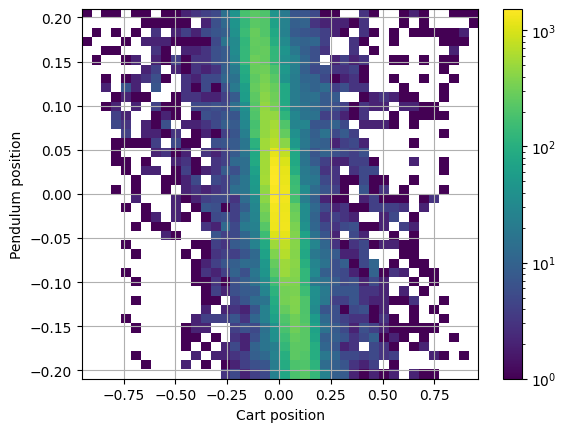

In [5]:
#plt.hist2d(, bins=(50, 50), cmap=plt.cm.Reds)
h = plt.hist2d(df[CART_POS], df[PEND_POS], bins=40, norm=LogNorm())
plt.colorbar(h[3])
plt.grid()
plt.xlabel ("Cart position")
plt.ylabel ("Pendulum position")
plt.show()


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

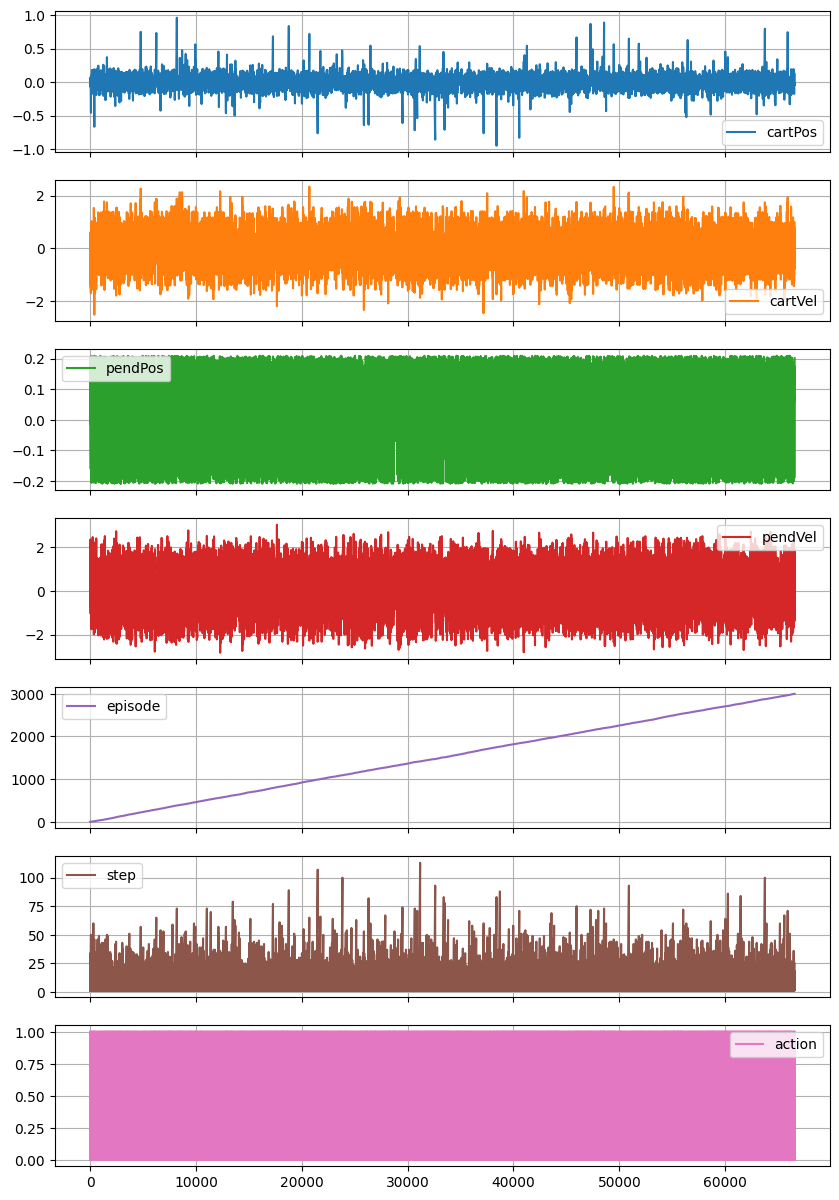

In [6]:
df.plot(subplots=True, figsize=(10,15), grid=True)

# Generate pattern data 

In [7]:
#############################################
#### HELPER FUNCTIONS FOR PATTERN GENERATION
#############################################
def create_training_data(data, input_col, target_col, window_size=1, training_pattern_percent=0.7):

    data_train = data

    mean_in, std_in = mean_and_std(input_col, data_train)
    mean_out, std_out = mean_and_std(target_col, data_train)
    #data_plot.plot_hist_df(data_train, input_col)
    #data_plot.plot_timeseries_df(data_train, input_col)
    print(f"mean in = {mean_in}" )
    print(f"std in = {std_in}")
    print(f"mean out =  {mean_out}")
    print(f"std out = {std_out}")

    grouped = data_train.groupby(['episode'])

    inputs_all = []
    labels_all = []

    for g in grouped:
        # be sure that data inside a group is not shuffled # not sure if needed
        g = g[1].sort_values(by='step')

        past_history = window_size   # t-3, t-2, t-1, t
        future_target = 0  # t+1
        STEP = 1 # no subsampling of rows in data, e.g. only every i'th row

        # use pandas.DataFrame.values in order to get an numpy array from an pandas.DataFrame object

        inputs, labels = multivariate_data(dataset=g[input_col][:].values, target=g[target_col][:].values,
                                        start_index=0, end_index=g[input_col][:].values.shape[0]-future_target,
                                        history_size=past_history, target_size=future_target, step=STEP,
                                        single_step=True)

        ## Append data to whole set of patterns
        for i in range (0, len(inputs)):
            inputs_all.append(inputs[i])
            labels_all.append(labels[i])
  
    length = len(inputs_all)

    c = list(zip(inputs_all, labels_all))
    np.random.shuffle(c)
    inputs_all, labels_all = zip(*c)

    split = int(training_pattern_percent * length)

    inputs_all = np.array(inputs_all)
    labels_all = np.array(labels_all)

    return ((inputs_all[0:split], labels_all[0:split]), (inputs_all[split:], labels_all[split:])), mean_in, std_in, mean_out, std_out


def mean_and_std(columns, data):
    mean = np.zeros(len(columns))
    std = np.zeros(len(columns))
    index = 0
    for c in columns:
        mean[index], std[index] = get_normalizations(data[c])
        index = index + 1
    return mean, std

def get_normalizations(data):
    mean = data.mean()
    std = data.std()
    return mean, std

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
       end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data, dtype=np.float32), np.array(labels, dtype=np.float32)



def prepare_data(df, input_col, target_col, window_size, training_batch_size=50, validation_batch_size=50, training_pattern_percent=0.7):
    
    global x_train_multi, y_train_multi
    
    ###################
    ## PREPARE DATASET
    ###################
    ((x_train_multi, y_train_multi), (x_val_multi, y_val_multi)), mean_in, std_in, mean_out, std_out = \
                                    create_training_data(df, input_col, target_col, window_size=window_size,
                                                        training_pattern_percent=training_pattern_percent)

    print('trainData: Single window of past history : {}'.format(x_train_multi[0].shape))
    print('trainData: Single window of future : {}'.format(y_train_multi[1].shape))
    print('valData: Single window of past history : {}'.format(x_val_multi[0].shape))
    print('valData: Single window of future : {}'.format(y_val_multi[1].shape))
    print('trainData: number of trainingsexamples: {}'.format(x_train_multi.shape))
    print('valData: number of trainingsexamples: {}'.format(x_val_multi.shape))

    train_data = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
    #train_data = train_data.cache().shuffle(max_training_pattern).batch(training_batch_size).repeat()
    train_data = train_data.shuffle(x_train_multi.shape[0]).batch(training_batch_size).repeat()

    val_data = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
    val_data = val_data.batch(validation_batch_size).repeat()
    input_shape = x_train_multi[0].shape[-2:]
    return train_data, val_data, input_shape, mean_in, std_in, mean_out, std_out


In [8]:
window_size=4
input_col = [CART_POS, CART_VEL, PEND_POS, PEND_VEL, ACTION]
target_col = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

train_data, val_data, input_shape, mean_in, std_in, mean_out, std_out =  \
            prepare_data(df, input_col, target_col, window_size=window_size, training_pattern_percent=0.7)

print ("Input-Shape: ", input_shape)

mean in = [-0.00078866 -0.00841681  0.00210174  0.01757488  0.49781404]
std in = [0.09598858 0.53209906 0.09220948 0.78189055 0.49999898]
mean out =  [-0.00078866 -0.00841681  0.00210174  0.01757488]
std out = [0.09598858 0.53209906 0.09220948 0.78189055]
trainData: Single window of past history : (4, 5)
trainData: Single window of future : (4,)
valData: Single window of past history : (4, 5)
valData: Single window of future : (4,)
trainData: number of trainingsexamples: (38192, 4, 5)
valData: number of trainingsexamples: (16369, 4, 5)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Input-Shape:  (4, 5)


# Create Cartpole state-transition model

In [9]:
def build_single_step_model(mean_in, std_in, mean_out, std_out, input_shape, optimizer=tf.keras.optimizers.RMSprop()):

    print(f"mean = {mean_in}, std = {std_in}, mean = {mean_out}, std = {std_out}")
    single_step_model = tf.keras.models.Sequential()
        
    single_step_model.add(tf.keras.layers.Lambda(lambda x: (x - mean_in) / std_in, input_shape=input_shape)) #, dtype=np.float32))
    #single_step_model.add(tf.keras.layers.Flatten())
    #single_step_model.add(tf.keras.layers.Dense(20, activation="sigmoid"))
    single_step_model.add(tf.keras.layers.LSTM(50, input_shape=input_shape, dtype=np.float32))
    single_step_model.add(tf.keras.layers.Dense(len(mean_out), activation="linear"))

    single_step_model.compile(optimizer=optimizer, loss="mse")

    return single_step_model

# V2 Transformer MODEL

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Input
from tensorflow.keras.models import Model

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]

        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        scaled_attention, _ = scaled_dot_product_attention(q, k, v)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output

def scaled_dot_product_attention(q, k, v, mask=None):
    """Calculate the attention weights."""
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

# Positional Encoding
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)




class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = Dense(d_model)
        self.pos_encoding = positional_encoding(input_shape[0], d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training)
        
        return x


class TimeSeriesTransformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape, output_dim, rate=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_shape, rate)
        self.final_layer = Dense(output_dim)

    def call(self, x, training=False):
        mask = None  # Implement masking logic here if needed
        enc_output = self.encoder(x, training, mask)
        final_output = self.final_layer(enc_output[:, -1])
        return final_output

def build_transformer_model(mean_in, std_in, mean_out, std_out, input_shape, num_layers=2, d_model=64, num_heads=4, dff=256, rate=0.1):
    input_dim = input_shape[-1]
    output_dim = len(mean_out)
    transformer = TimeSeriesTransformer(num_layers, d_model, num_heads, dff, input_shape, output_dim, rate)

    inputs = Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda x: (x - mean_in) / std_in)(inputs)  # Normalization
    outputs = transformer(x)

    # model = Model(inputs=inputs, outputs=outputs)
    model = TimeSeriesTransformer(num_layers, d_model, num_heads, dff, input_shape, output_dim, rate)
    model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse')
    return model


## LSTM

In [11]:
import os
modelpath="lstm_model"
if not os.path.exists(modelpath):
    os.makedirs(modelpath)
max_epochs=1000
steps_per_epoch = 100
validation_steps = 100
validation_freq = 1

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=True)
mc_trainLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(modelpath, "model_bestTrainLoss"), monitor='loss', verbose=1, save_best_only=True, mode=min)
mc_valLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(modelpath, "model_bestValLoss"), monitor='val_loss', verbose=1, save_best_only=True, mode=min)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = ".\model_logs_tb", histogram_freq=1)


model = build_single_step_model(mean_in, std_in, mean_out, std_out, input_shape)
history = model.fit(train_data, epochs=max_epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=val_data, validation_steps=validation_steps, validation_freq=validation_freq,
                        callbacks=[mc_trainLoss_callback, mc_valLoss_callback, es_callback, tensorboard_callback])
model.save(os.path.join(modelpath, 'lstm_model'))


mean = [-0.00078866 -0.00841681  0.00210174  0.01757488  0.49781404], std = [0.09598858 0.53209906 0.09220948 0.78189055 0.49999898], mean = [-0.00078866 -0.00841681  0.00210174  0.01757488], std = [0.09598858 0.53209906 0.09220948 0.78189055]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 100 steps, validate on 100 steps
Epoch 1/1000
 96/100 [===========================>..] - ETA: 0s - loss: 0.0510
Epoch 00001: loss improved from inf to 0.04907, saving model to lstm_model\model_bestTrainLoss

Epoch 00001: val_loss improved from inf to 0.00372, saving model to lstm_model\model_bestValLoss
100/100 [==============================] - 1s 10ms/step - loss: 0.0491 - val_loss: 0.0037
Epoch 2/1000
 90/100 [==========================>...] - ETA: 0s - loss: 0.0016
Epoch 00002: loss improved from 0.04907 to 0.00149, saving model to lstm_model\model_bestTrainLoss

Epoch 00002: val_loss improved from 0.00372 to 0.00070, saving model to lstm_model\model_bes

## Transformer

In [12]:
modelpath="new_transf_lr01"
if not os.path.exists(modelpath):
    os.makedirs(modelpath)
max_epochs=1000
steps_per_epoch = 100
validation_steps = 100
validation_freq = 1
lr=0.01

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=True)
# mc_trainLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath="%s.bestTrainLoss" % modelpath, monitor='loss', verbose=1, save_best_only=True, mode=min)
mc_valLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(modelpath, "model_bestValLoss"), monitor='val_loss', verbose=1, save_best_only=True, mode=min)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = ".\model_logs_tb", histogram_freq=1)

# Build the Transformer model
# model = build_transformer_model(mean_in, std_in, mean_out, std_out, input_shape=input_shape)
model = TimeSeriesTransformer(num_layers=2, d_model=64, num_heads=4, dff=256, 
                              input_shape=input_shape, output_dim=len(mean_out), rate=lr)
model.compile(optimizer="adam", loss="mse")

history = model.fit(train_data, epochs=max_epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=val_data, validation_steps=validation_steps, validation_freq=validation_freq,
                        callbacks=[mc_valLoss_callback ,es_callback])
model.save(os.path.join(modelpath, 'transformer_model'), save_format='tf')

Train on 100 steps, validate on 100 steps
Epoch 1/1000
 94/100 [===========================>..] - ETA: 0s - loss: 0.0966
Epoch 00001: val_loss improved from inf to 0.00353, saving model to new_transf_lr01\model_bestValLoss
100/100 [==============================] - 2s 18ms/step - loss: 0.0915 - val_loss: 0.0035
Epoch 2/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0120
Epoch 00002: val_loss improved from 0.00353 to 0.00274, saving model to new_transf_lr01\model_bestValLoss
100/100 [==============================] - 1s 9ms/step - loss: 0.0119 - val_loss: 0.0027
Epoch 3/1000
 96/100 [===========================>..] - ETA: 0s - loss: 0.0092
Epoch 00003: val_loss improved from 0.00274 to 0.00142, saving model to new_transf_lr01\model_bestValLoss
100/100 [==============================] - 1s 9ms/step - loss: 0.0092 - val_loss: 0.0014
Epoch 4/1000
 94/100 [===========================>..] - ETA: 0s - loss: 0.0076
Epoch 00004: val_loss improved from 0.00142 to 0.00133, savi

# Evaluate model quality

### Sample new data from environment and determine episode with most steps

In [13]:
dfEval = sample_data(episodes=100, seed=111)
dfEval.describe()
row_max_steps = dfEval[dfEval.step == dfEval.step.max()]
dfEval = dfEval[dfEval.episode==int(row_max_steps.episode)]

### Extract prediction bounds from training data

In [14]:
output_min = y_train_multi.min(axis=0)
output_max = y_train_multi.max(axis=0)
print ("min(output)_data: ", output_min)
print ("max(output)_data: ", output_max)

min(output)_data:  [-0.86143947 -2.5050364  -0.20941806 -2.8272533 ]
max(output)_data:  [0.9371568  2.3328724  0.20941928 3.0202355 ]


# Evaluate Transformer

### Evaluate neural network

In [15]:
import collections
modelpath = "new_transf_lr01"
# load model
# model = tf.keras.models.load_model(modelpath, compile=False)
transformer_model = TimeSeriesTransformer(num_layers=2, d_model=64, num_heads=4, dff=256, 
                              input_shape=input_shape, output_dim=len(mean_out), rate=0.1)
transformer_model.load_weights(f"{modelpath}/model_bestValLoss")
# model = tf.keras.models.load_model("new_model.bestValLoss", compile=False)
#model = tf.keras.models.load_model("model.h5.bestTrainLoss", compile=False)
#############################################################################
# in case of error: AttributeError: 'str' object has no attribute 'decode'
# => Downgrade h5py package to version 2.10.0: pip install h5py==2.10.0
#############################################################################

# FIFO-buffer that keeps the neural state
stateBuffer = collections.deque(maxlen=window_size)

# outputs of neural network will be stored here
transitions = []

for i in range (len(dfEval)): 
                            
    # estimation of first state
    if i < window_size: 
        state_data = np.float32([dfEval[CART_POS].values[i], dfEval[CART_VEL].values[i],
                               dfEval[PEND_POS].values[i], dfEval[PEND_VEL].values[i],
                               dfEval[ACTION].values[i]])
        stateBuffer.append(state_data)
        #print ("Filling initState: %s" % state_data)
    
    # predict successor state
    else: 
        
        ###########################
        # recall of neural network
        ###########################
        state = np.array([list(stateBuffer)])
        if i==5:
            print (state)
        netOutput = transformer_model.predict(np.float32(state))[0]
        
        # clip output to observed data bounds
        netOutput = np.clip(netOutput, output_min, output_max)
        
        # check if value bound was hit
        if np.any(netOutput == output_min) or np.any(netOutput == output_max):
            print ("Bound-hit at step: ", i, " => terminating further evaluation")
            break
        
        # append plotting data
        transitions.append ({
            CART_POS:netOutput[0], CART_VEL:netOutput[1],
            PEND_POS:netOutput[2], PEND_VEL:netOutput[3]
        })
        
        # update RNN state
        stateBuffer.append(np.float32([netOutput[0], netOutput[1], 
                                       netOutput[2], netOutput[3], 
                                       dfEval[ACTION].values[i]]))
        
dfNet = pd.DataFrame(transitions)

[[[ 0.03562063 -0.23339364  0.00100205  0.25643757  0.        ]
  [ 0.03095275 -0.4285299   0.0061308   0.5494364   1.        ]
  [ 0.02238215 -0.2334946   0.01711953  0.25869137  1.        ]
  [ 0.01609839 -0.03597371  0.02303162 -0.02777419  0.        ]]]
Bound-hit at step:  50  => terminating further evaluation


### Plot results

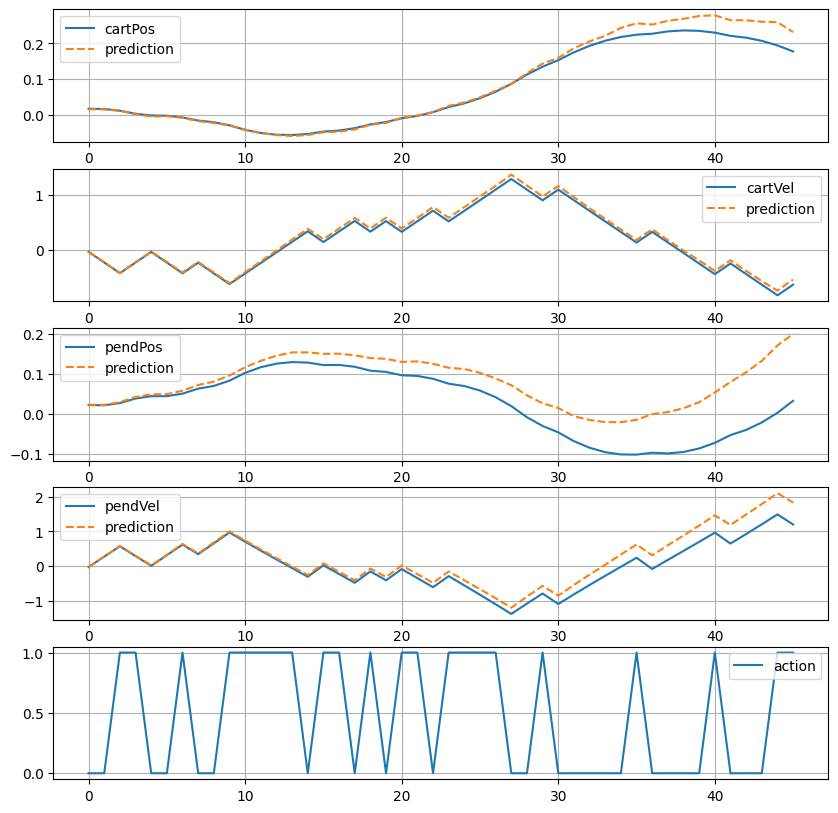

In [16]:
fig, axs = plt.subplots (5, 1, figsize=(10,10))

fields = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

for i in range (len(fields)):
    f = fields[i]
    axs[i].plot(range (len(dfNet)), dfEval[f].values[window_size:window_size+len(dfNet)], label=f)
    axs[i].plot(range (len(dfNet)), dfNet[f].values, label="prediction", ls="--")
    axs[i].grid()
    axs[i].legend(loc="best")
    
axs[4].plot(range (len(dfNet)), dfEval[ACTION].values[window_size:window_size+len(dfNet)], label=ACTION)
axs[4].grid()
axs[4].legend(loc="best")


In [17]:
import collections
modelpath = "lstm_model"
# load model
model = tf.keras.models.load_model(os.path.join(modelpath, "lstm_model"), compile=False)
# model = tf.keras.models.load_model("new_model.bestValLoss", compile=False)
#model = tf.keras.models.load_model("model.h5.bestTrainLoss", compile=False)
#############################################################################
# in case of error: AttributeError: 'str' object has no attribute 'decode'
# => Downgrade h5py package to version 2.10.0: pip install h5py==2.10.0
#############################################################################

# FIFO-buffer that keeps the neural state
stateBuffer = collections.deque(maxlen=window_size)

# outputs of neural network will be stored here
transitions = []

for i in range (len(dfEval)): 
                            
    # estimation of first state
    if i < window_size: 
        state_data = np.float32([dfEval[CART_POS].values[i], dfEval[CART_VEL].values[i],
                               dfEval[PEND_POS].values[i], dfEval[PEND_VEL].values[i],
                               dfEval[ACTION].values[i]])
        stateBuffer.append(state_data)
        #print ("Filling initState: %s" % state_data)
    
    # predict successor state
    else: 
        
        ###########################
        # recall of neural network
        ###########################
        state = np.array([list(stateBuffer)])
        if i==5:
            print (state)
        netOutput = model.predict(np.float32(state))[0]
        
        # clip output to observed data bounds
        netOutput = np.clip(netOutput, output_min, output_max)
        
        # check if value bound was hit
        if np.any(netOutput == output_min) or np.any(netOutput == output_max):
            print ("Bound-hit at step: ", i, " => terminating further evaluation")
            break
        
        # append plotting data
        transitions.append ({
            CART_POS:netOutput[0], CART_VEL:netOutput[1],
            PEND_POS:netOutput[2], PEND_VEL:netOutput[3]
        })
        
        # update RNN state
        stateBuffer.append(np.float32([netOutput[0], netOutput[1], 
                                       netOutput[2], netOutput[3], 
                                       dfEval[ACTION].values[i]]))
        
dfNet = pd.DataFrame(transitions)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[[[ 0.03562063 -0.23339364  0.00100205  0.25643757  0.        ]
  [ 0.03095275 -0.4285299   0.0061308   0.5494364   1.        ]
  [ 0.02238215 -0.2334946   0.01711953  0.25869137  1.        ]
  [ 0.01783804 -0.03979745  0.0219157  -0.02916797  0.        ]]]
Bound-hit at step:  61  => terminating further evaluation


### LSTM

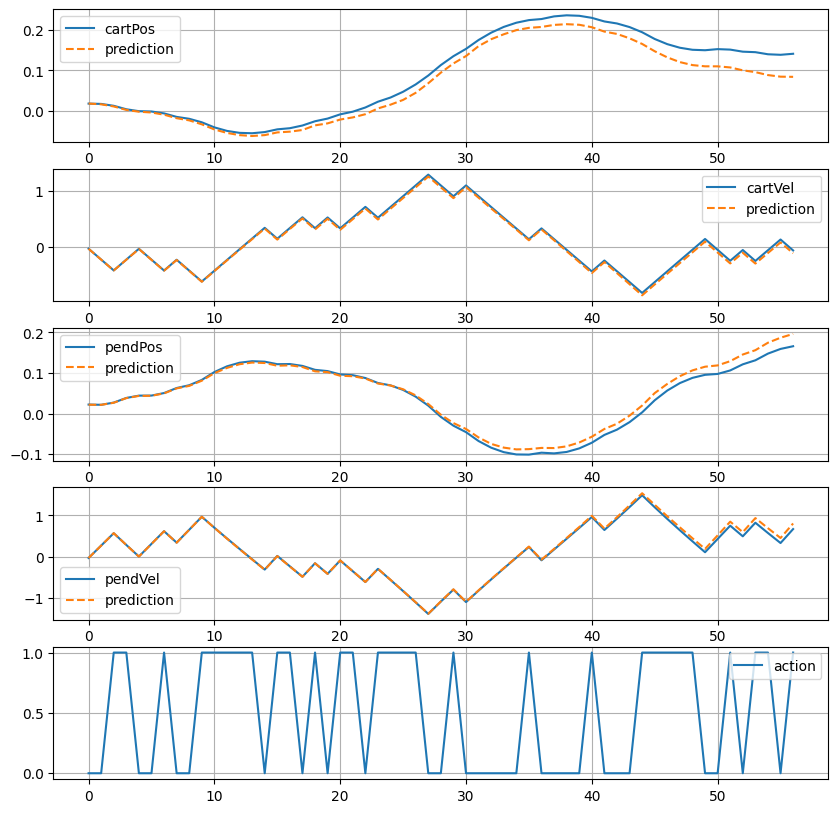

In [18]:
fig, axs = plt.subplots (5, 1, figsize=(10,10))

fields = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

for i in range (len(fields)):
    f = fields[i]
    axs[i].plot(range (len(dfNet)), dfEval[f].values[window_size:window_size+len(dfNet)], label=f)
    axs[i].plot(range (len(dfNet)), dfNet[f].values, label="prediction", ls="--")
    axs[i].grid()
    axs[i].legend(loc="best")
    
axs[4].plot(range (len(dfNet)), dfEval[ACTION].values[window_size:window_size+len(dfNet)], label=ACTION)
axs[4].grid()
axs[4].legend(loc="best")


In [ ]:
tf.executing_eagerly()